**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature ranging from 700C and 1000C. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In an MSR, tritium is generated, initial

## [Problem Statement](#toc)<a id="problem"></a>

The project below considers tritium flow co-currently, at velocity v, with the salt coolant,FLiNak, through a heat exchangers main coolant leg.  

In [2]:
'''Domain'''

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 4.5*(3/4+2*1)
    radius_i = 3/4 / 2
    radius_o = radius_i + 1
    coolant = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height, radius=radius_i)
    pin = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height, radius=radius_o)

    plo = pv.Plotter(notebook=True,shape=(1,2)) 

    plo.subplot(0,0)
    plo.add_mesh(coolant, color='red', opacity=1.0,)
    plo.add_mesh(pin, color='tan', opacity=0.99)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Z')

    pin = pin.triangulate()
    tmp = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height*1.1, radius=radius_i).triangulate()
    tmp.flip_normals()

    pin = pin.boolean_cut(tmp)
    plo.subplot(0,1)
    plo.add_mesh(pin, 'grey')
    plo.add_mesh(pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height*.98, radius=radius_i), 'red')
    cpos = plo.show(window_size=[800, 600])

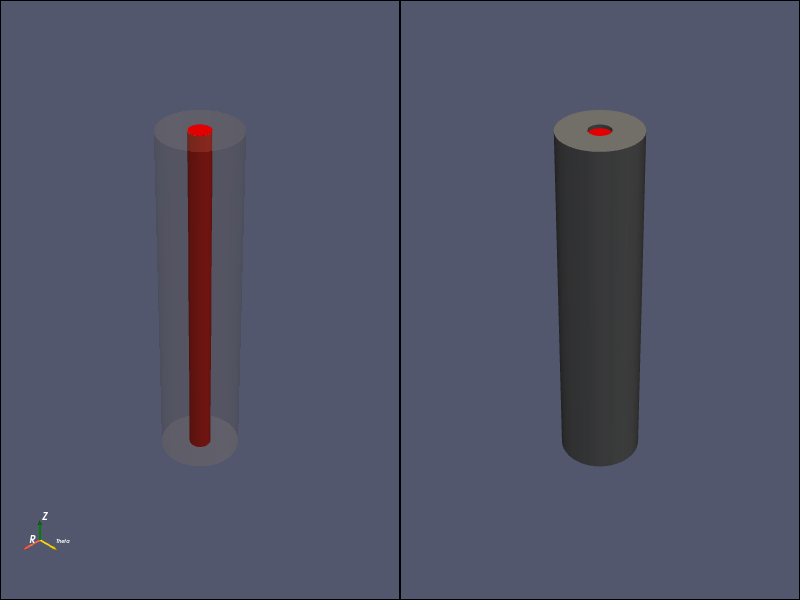

In [3]:
show_domain()

## [Objectives](#toc)<a id="obj"></a>

- Text...

- Text...

## [Approach](#toc)<a id="app"></a>

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 


### [MOOSE Kernels](#toc)<a id="kernels"></a>

The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. X term: 
 + [interface](./include/kernels/X.h) and [implementation](./src/kernels/X.C).

### [Setup](#toc)<a id="setup"></a>

In [ ]:
'''Domain'''

x_a = 0
x_b = 1000

x_length = x_b - x_a

In [ ]:
'''Parameters'''

diff_coeff = 2.04
s_source = 0

In [ ]:
'''Data (boundary conditions)'''

u_a = 4.17
transfer_coeff_right = 2.0

In [ ]:
'''FEM Solution'''

n_felem = 10

order = 'first'

n_plot_pts = n_felem + 1

from tools.toolkit import write_engy5310_p1_1d_input_file

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, 
                                transfer_coeff_right=transfer_coeff_right,
                                diff_coeff=diff_coeff,
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                use_moose_neumann_bc=True,
                                file_name='input.hit')

In [ ]:
!./neutron-ball-opt -i input.hit

## [Results and Analysis](#toc)<a id="ranalysis"></a>

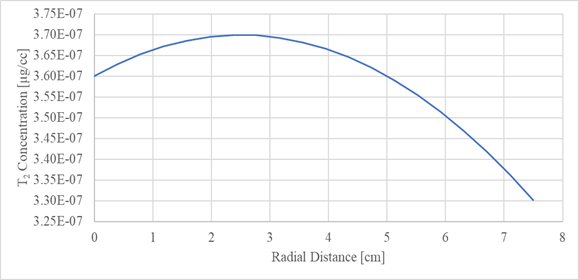

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()